/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Loading training data...
Loading test data...
Augmenting minority classes...
Final class distribution: {'3': 2159, '4': 2159, '1': 2159, '2': 2159, '5': 2159}

Classification Report:

              precision    recall  f1-score   support

           1       0.93      0.81      0.87       270
           2       0.78      0.70      0.74       253
           3       0.68      0.71      0.69       236
           4       0.63      0.66      0.65       197
           5       0.62      0.84      0.71       112

    accuracy                           0.74      1068
   macro avg       0.73      0.75      0.73      1068
weighted avg       0.75      0.74      0.74      1068

 Accuracy: 73.88%


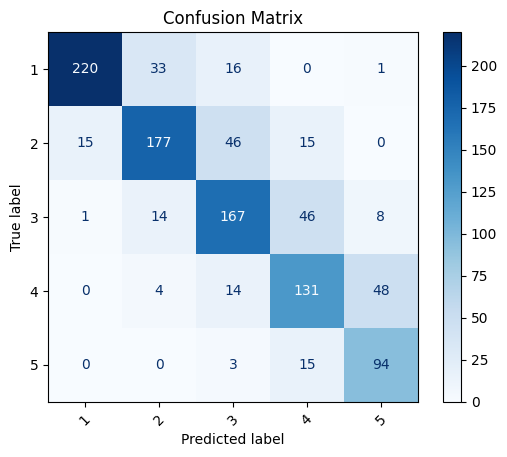


5-fold CV Accuracy: 0.6860 ± 0.0757


In [1]:
!pip install -q albumentations scikit-image

# === IMPORTS ===
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.filters import sobel, gabor

import albumentations as A

# === PATHS & CONSTANTS ===
IMG_SIZE = 128
train_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/train/images'
test_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images'

# === FEATURE EXTRACTION ===
def extract_features(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_gray = rgb2gray(img)
    img_gray_u8 = (img_gray * 255).astype(np.uint8)

    # HOG
    hog_feat = hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(3, 3), feature_vector=True)

    # LBP
    lbp = local_binary_pattern(img_gray_u8, P=8, R=1, method='uniform')
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    hist_lbp = hist_lbp.astype("float") / (hist_lbp.sum() + 1e-7)

    # GLCM
    glcm = graycomatrix(img_gray_u8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    glcm_props = [graycoprops(glcm, prop)[0, 0] for prop in 
                  ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']]

    # Hu Moments
    hu = cv2.HuMoments(cv2.moments(img_gray_u8)).flatten()

    # Sobel
    sobel_edge = sobel(img_gray)
    sobel_hist, _ = np.histogram(sobel_edge.ravel(), bins=10, range=(0, 1))
    sobel_hist = sobel_hist.astype('float') / (sobel_hist.sum() + 1e-7)

    # Gabor
    gabor_real, _ = gabor(img_gray, frequency=0.6)
    gabor_hist, _ = np.histogram(gabor_real.ravel(), bins=10, range=(0, gabor_real.max()))
    gabor_hist = gabor_hist.astype('float') / (gabor_hist.sum() + 1e-7)

    # RGB Hist
    rgb_hist = []
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [16], [0, 256]).flatten()
        rgb_hist.extend(hist / (hist.sum() + 1e-7))

    # Color Moments
    moments = []
    for i in range(3):
        ch = img[:, :, i].flatten()
        moments.extend([np.mean(ch), np.std(ch), np.mean((ch - np.mean(ch))**3)])

    return np.concatenate([hog_feat, hist_lbp, glcm_props, hu, sobel_hist, gabor_hist, rgb_hist, moments])

# === LOAD DATA ===
def load_data(folder):
    paths = glob(os.path.join(folder, '*.jpg'))
    imgs, labels = [], []
    for p in paths:
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = os.path.basename(p).split("_")[-2]
        imgs.append(img)
        labels.append(label)
    return imgs, np.array(labels)

# === AUGMENTATION ===
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomGamma(p=0.3),
    A.MotionBlur(p=0.3),
    A.OneOf([A.GaussNoise(), A.ImageCompression(), A.ChannelShuffle()], p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.0, rotate_limit=0, p=0.5),
    A.CLAHE(p=0.2),
    A.HueSaturationValue(p=0.3),
    A.GridDistortion(p=0.2)
])

def augment_minority_classes(imgs, labels, augment, le):
    print("Augmenting minority classes...")
    counts = Counter(labels)
    max_count = max(counts.values())

    new_imgs, new_labels = list(imgs), list(labels)
    for cls in counts:
        cls_imgs = [x for x, y in zip(imgs, labels) if y == cls]
        for _ in range(max_count - counts[cls]):
            img = cls_imgs[np.random.randint(len(cls_imgs))]
            aug_img = augment(image=img)['image']
            new_imgs.append(aug_img)
            new_labels.append(cls)

    print("Final class distribution:", dict(Counter(new_labels)))
    feats = [extract_features(img) for img in new_imgs]
    return np.array(feats), le.transform(new_labels)

# === LOAD TRAIN & TEST ===
print("Loading training data...")
imgs_train, y_train_raw = load_data(train_img_dir)
print("Loading test data...")
imgs_test, y_test_raw = load_data(test_img_dir)

le = LabelEncoder()
le.fit(np.concatenate([y_train_raw, y_test_raw]))
y_test_enc = le.transform(y_test_raw)

# === AUGMENTATION & FEATURE EXTRACTION ===
X_train_aug, y_train_enc = augment_minority_classes(imgs_train, y_train_raw, augment, le)
X_test = np.array([extract_features(img) for img in imgs_test])

# === SCALING ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_aug)
X_test_scaled = scaler.transform(X_test)

# === CLASSIFIER ===
rf = RandomForestClassifier(n_estimators=300, max_depth=30, class_weight='balanced', random_state=42)
rf.fit(X_train_scaled, y_train_enc)

# === PREDICTIONS & REPORT ===
y_pred = rf.predict(X_test_scaled)

print("\nClassification Report:\n")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
print(" Accuracy: {:.2f}%".format(accuracy_score(y_test_enc, y_pred)*100))

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# === CROSS VALIDATION ===
scores = cross_val_score(rf, X_train_scaled, y_train_enc, cv=5)
print(f"\n5-fold CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")



In [2]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
import time

# === INFERENCE TIME (and FPS) ===
start_time = time.time()
_ = rf.predict(X_test_scaled)  # Already predicted above, but used for timing
inference_time = time.time() - start_time
fps = len(X_test_scaled) / inference_time

print(f"\nInference Time: {inference_time:.4f} seconds")
print(f" FPS (Frames per Second): {fps:.2f}")

# === PER-CLASS PRECISION, RECALL, F1 ===
precision, recall, f1, _ = precision_recall_fscore_support(y_test_enc, y_pred, zero_division=0)
print("\n Per-Class Metrics:")
for i, cls in enumerate(le.classes_):
    print(f"{cls:15} | Precision: {precision[i]:.4f} | Recall: {recall[i]:.4f} | F1-score: {f1[i]:.4f}")

# === mAP (Mean Average Precision) ===
# One-vs-Rest probability prediction needed for mAP and AUC
if hasattr(rf, "predict_proba"):
    y_score = rf.predict_proba(X_test_scaled)
    y_test_bin = np.eye(len(le.classes_))[y_test_enc]
    mAP = average_precision_score(y_test_bin, y_score, average="macro")
    auc = roc_auc_score(y_test_bin, y_score, average="macro")

    print(f"\n Mean Average Precision (mAP): {mAP:.4f}")
    print(f" Overall AUC Score: {auc:.4f}")
else:
    print("\n Classifier does not support probability estimates, mAP and AUC cannot be computed.")



Inference Time: 0.2790 seconds
 FPS (Frames per Second): 3828.52

 Per-Class Metrics:
1               | Precision: 0.9322 | Recall: 0.8148 | F1-score: 0.8696
2               | Precision: 0.7763 | Recall: 0.6996 | F1-score: 0.7360
3               | Precision: 0.6789 | Recall: 0.7076 | F1-score: 0.6929
4               | Precision: 0.6329 | Recall: 0.6650 | F1-score: 0.6485
5               | Precision: 0.6225 | Recall: 0.8393 | F1-score: 0.7148

 Mean Average Precision (mAP): 0.8035
 Overall AUC Score: 0.9491


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()



Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.81      0.87       270
           2       0.78      0.69      0.73       253
           3       0.67      0.74      0.70       236
           4       0.64      0.62      0.63       197
           5       0.60      0.84      0.70       112

    accuracy                           0.73      1068
   macro avg       0.72      0.74      0.73      1068
weighted avg       0.75      0.73      0.74      1068



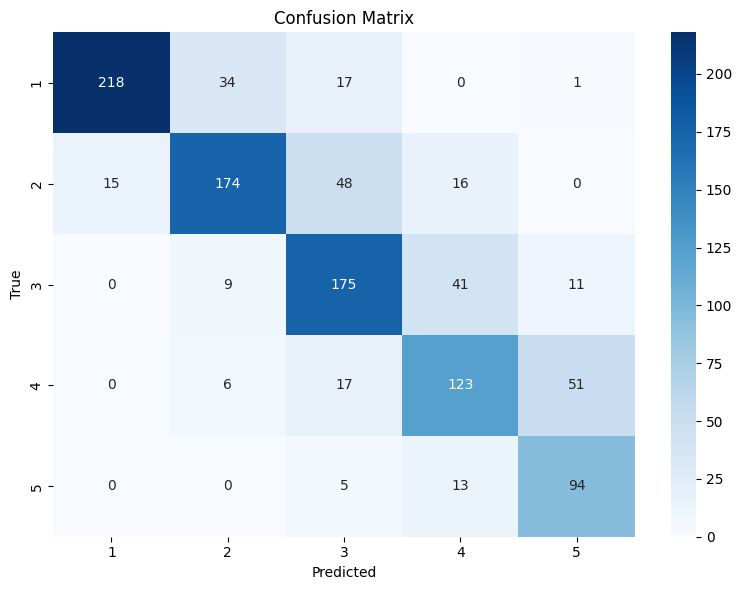

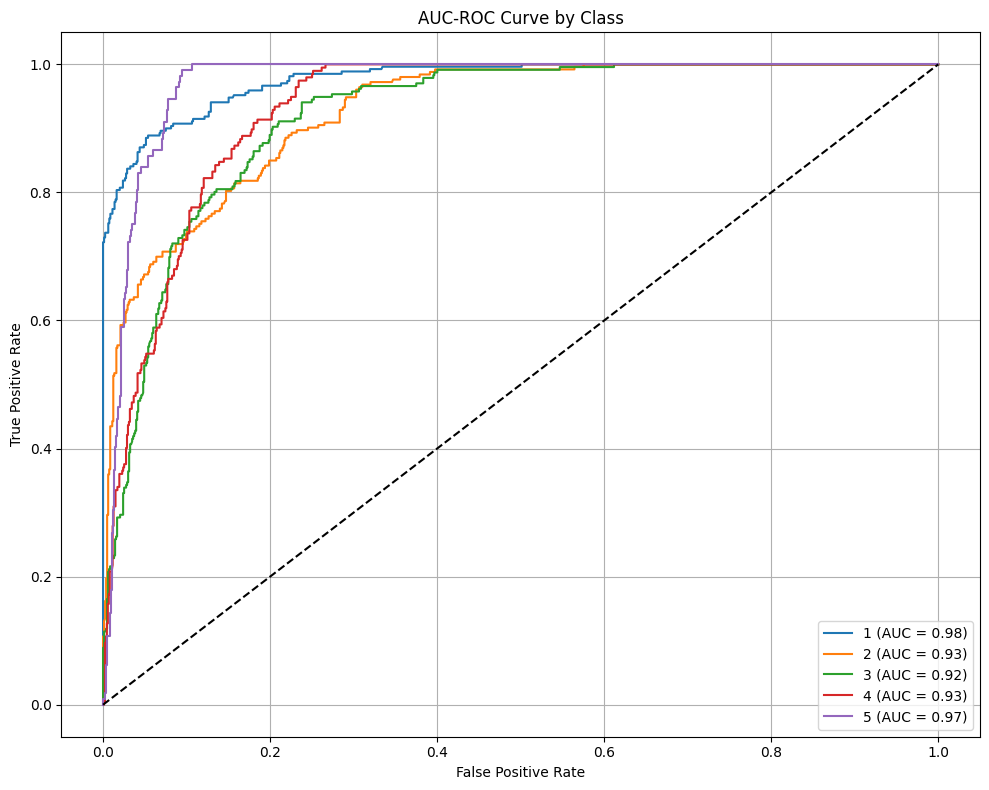


F1 Scores:
1: 0.87
2: 0.73
3: 0.70
4: 0.63
5: 0.70

Mean Average Precision (mAP):
mAP: 0.7845


In [1]:
#XGBoost
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, average_precision_score
from xgboost import XGBClassifier
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
import albumentations as A

# Configuration
IMG_SIZE = 128
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS

augment = A.Compose([
    A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5), A.RandomGamma(p=0.3), A.MotionBlur(p=0.3),
    A.CLAHE(p=0.2), A.GaussNoise(p=0.3), A.HueSaturationValue(p=0.3), A.GridDistortion(p=0.2)
])

# Load data
def load_data_from_folder(folder):
    image_paths = glob(os.path.join(folder, '*.jpg'))
    images, labels = [], []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = path.split("_")[-2]
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Sample Paths (adjust based on real environment)
train_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/train/images'
test_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images'

X_train, y_train = load_data_from_folder(train_img_dir)
X_test, y_test = load_data_from_folder(test_img_dir)

# Balance minority classes
def augment_minority_classes(X, y, augment):
    counts = Counter(y)
    max_count = max(counts.values())
    new_X, new_y = list(X), list(y)
    for label in counts:
        imgs = [img for img, lbl in zip(X, y) if lbl == label]
        for _ in range(max_count - counts[label]):
            img = imgs[np.random.randint(len(imgs))]
            aug_img = augment(image=img)['image']
            new_X.append(aug_img)
            new_y.append(label)
    return np.array(new_X), np.array(new_y)

X_train_aug, y_train_aug = augment_minority_classes(X_train, y_train, augment)

# Feature Extraction
def extract_features(images):
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # HOG
        hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)

        # LBP
        lbp = local_binary_pattern(gray, P=LBP_POINTS, R=LBP_RADIUS, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3),
                                   range=(0, LBP_POINTS + 2), density=True)

        # GLCM
        glcm = graycomatrix((gray / 4).astype(np.uint8), distances=[1], angles=[0], symmetric=True, normed=True)
        glcm_props = [graycoprops(glcm, prop).ravel()[0] for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']]

        # Hu Moments
        hu = cv2.HuMoments(cv2.moments(gray)).flatten()

        # Sobel
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel_stats = [np.mean(sobelx), np.std(sobelx), np.mean(sobely), np.std(sobely)]

        # Color Histogram
        color_hist = []
        for i in range(3):
            hist = cv2.calcHist([img], [i], None, [32], [0, 256]).flatten()
            color_hist.extend(hist / hist.sum())

        # Contour-based Shape
        contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            c = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(c)
            aspect_ratio = float(w)/h
            area = cv2.contourArea(c)
            hull = cv2.convexHull(c)
            hull_area = cv2.contourArea(hull)
            solidity = float(area) / hull_area if hull_area > 0 else 0
        else:
            aspect_ratio, solidity = 0, 0

        feature_vector = np.hstack([hog_feat, lbp_hist, glcm_props, hu, sobel_stats, color_hist, [aspect_ratio, solidity]])
        features.append(feature_vector)
    return np.array(features)

X_train_feat = extract_features(X_train_aug)
X_test_feat = extract_features(X_test)

# Encode Labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_aug)
y_test_enc = le.transform(y_test)

# Train XGBoost Classifier
xgb = XGBClassifier(n_estimators=100, max_depth=6, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train_feat, y_train_enc)

# Predict
preds = xgb.predict(X_test_feat)
probs = xgb.predict_proba(X_test_feat)

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test_enc, preds, target_names=le.classes_))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_enc, preds), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve((y_test_enc == i).astype(int), probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("AUC-ROC Curve by Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nF1 Scores:")
for i, cls in enumerate(le.classes_):
    print(f"{cls}: {f1_score((y_test_enc == i).astype(int), (preds == i).astype(int)):.2f}")

print("\nMean Average Precision (mAP):")
print(f"mAP: {average_precision_score(np.eye(len(le.classes_))[y_test_enc], probs, average='macro'):.4f}")

In [2]:
import time
from sklearn.metrics import precision_score

# ---------------------- Inference Time & FPS ---------------------- #
start_time = time.time()
_ = xgb.predict(X_test_feat)
end_time = time.time()

total_time = end_time - start_time
avg_inference_time = total_time / len(X_test_feat)
fps = len(X_test_feat) / total_time

print(f"\nTotal Inference Time: {total_time:.4f} seconds")
print(f"Average Inference Time per Image: {avg_inference_time:.4f} seconds")
print(f"Frames Per Second (FPS): {fps:.2f}")

# ---------------------- Per-Class Precision & F1 ---------------------- #
print("\nPer-Class Precision & F1 Score:")
for i, cls in enumerate(le.classes_):
    precision = precision_score((y_test_enc == i).astype(int), (preds == i).astype(int))
    f1 = f1_score((y_test_enc == i).astype(int), (preds == i).astype(int))
    print(f"{cls}: Precision = {precision:.2f}, F1 Score = {f1:.2f}")

# ---------------------- Overall AUC Score ---------------------- #
# One-vs-Rest AUC using macro average
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test_enc, classes=range(len(le.classes_)))
overall_auc = auc(*roc_curve(y_test_bin.ravel(), probs.ravel())[0:2])
print(f"\nOverall AUC Score (macro): {overall_auc:.4f}")

# ---------------------- mAP ---------------------- #
mAP = average_precision_score(y_test_bin, probs, average='macro')
print(f"Mean Average Precision (mAP): {mAP:.4f}")



Total Inference Time: 0.0554 seconds
Average Inference Time per Image: 0.0001 seconds
Frames Per Second (FPS): 19274.12

Per-Class Precision & F1 Score:
1: Precision = 0.94, F1 Score = 0.87
2: Precision = 0.78, F1 Score = 0.73
3: Precision = 0.67, F1 Score = 0.70
4: Precision = 0.64, F1 Score = 0.63
5: Precision = 0.60, F1 Score = 0.70

Overall AUC Score (macro): 0.9506
Mean Average Precision (mAP): 0.7845
